In [1]:
import numpy as np              # numpy is a general-purpose math package
import yt                       # yt is the data vizualization package
from yt.units import *          # this lets you get things like speed of light in proper units just by typing 'c'
from astropy.table import Table # this is needed for reading in various foggie data byproducts
from astropy.io import ascii    # this too
import matplotlib.pyplot as plt # this is the standard python plotting package, very useful!
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import math
from ipynb.fs.defs.FRB_and_Projection_functions import projection
from scipy import optimize
import pwlf # A library for fitting continuous piecewise linear functions to data (Returns cut-off radius)
import os #for the lacie part 

# These imports are FOGGIE-specific files
from foggie.utils.consistency import *
from foggie.utils.foggie_load import *

home_dir = '/Users/hylee/foggie/'
laptop_root_dir = home_dir + 'foggie_sims/' # root directory where sims are stored on the laptop
hd_root_dir = '/Volumes/LaCie/' # root directory where sims are stored on the hard drive

root_dir = hd_root_dir # have this as either laptop_root_dir or hd_root_dir depending on where the simulation is stored
code_path = '/Users/hylee/coding/foggie/foggie/' #path to the cloned github repo

# everything above this is general path, and below this is specific to a given halo
halo = '8508' # which halo
simulation_dir = root_dir + 'halo_00' + halo + '/nref11c_nref9f/' # path where the foggie simulations are stored
output_dir = home_dir + 'foggie_output/halo_00' + halo + '/nref11c_nref9f/Metallicity_x/' # path where all the outputs will be stored
track_dir = code_path + 'halo_infos/00' + halo + '/nref11c_nref9f/'
track_name = code_path + 'halo_tracks/00' + halo + '/nref11n_selfshield_15/halo_track_200kpc_nref9' #these need to be provided to foggie_load()

In [2]:
def frb_projection(ds, field, axis, data_source, width, resolution, weight_field = None):
    proj = ds.proj(("gas", field), axis, center = ds.halo_center_kpc, data_source = data_source, method="sum")
    width = (width, "kpc")
    resolution = [resolution,resolution]
    frb = proj.to_frb(width, resolution, center = ds.halo_center_kpc)
    return frb

In [3]:
def radius_func(od, size, res):
    OD_Qua=[]
    OD_Rad=[]  #OD_Rad & OD_Met HAVE to be defined specifically inside func1/before for loop
    for i in range(70):
        for j in range(70):
            this_quantity_value = od[i][j]
            xindex = i
            yindex = j
            radius = (math.sqrt(((yindex-34)**2+(xindex-34)**2)))*(size/res)
            OD_Qua.append(this_quantity_value)
            OD_Rad.append(radius)
    return OD_Rad, OD_Qua

In [4]:
def binning_func(OD_Rad, OD_Qua, max_radius, min_radius, binsize):
    index = 0 
    quantitylist = []
    sort = np.argsort(OD_Rad)
    sorted_radius = np.array(OD_Rad)[sort]
    sorted_quantity = np.array(OD_Qua)[sort]
    radiuslist = np.arange(min_radius, max_radius, binsize) + binsize/2
    while index < len(radiuslist):
        left_edge = index*binsize
        right_edge = left_edge + binsize 
        new_quantity = np.array(sorted_quantity)[(left_edge <= sorted_radius) & (sorted_radius < right_edge)]
        quantitylist.append((np.mean(new_quantity)))
        index +=1
    return radiuslist, quantitylist

In [5]:
def piecewise_linear(x, x0, y0, k1, k2): 
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

In [6]:
def plotting(xvalue, yvalue_origdata, yvalue_cutoff, color_original, color_cutoff, plotlabel_linedot,
            plotlabel_segment):
    fig1 = plt.figure()
    plt.plot(xvalue, yvalue_origdata, color_original, label=plotlabel_linedot)
    plt.plot(xvalue, yvalue_cutoff, color_cutoff, label=plotlabel_segment)
    plt.legend(loc="upper right", fontsize = 15)
    plt.xlabel("Radius from galactic center [kpc]", fontsize = 12.5)
    plt.ylabel("Projected metallicity [log10 ZSun]", fontsize = 12.5)
    plt.xticks(fontsize = fontsize/1.5)
    plt.yticks(fontsize = fontsize/1.5)
    return fig1

In [7]:
def get_density_cut(current_time):
    t1, t2 = 8.628, 10.754 # Gyr; corresponds to z1 = 0.5 and z2 = 0.25
    rho1, rho2 = 2e-26, 2e-27 # g/cm**3
    t = np.float64(current_time)
    rho_cut = np.piecewise(t, [t < t1, (t >= t1) & (t <= t2), t > t2], [rho1, lambda t: rho1 + (t - t1) * (rho2 - rho1) / (t2 - t1), rho2])
    return rho_cut

In [8]:
DDLIST = []
for file in os.listdir(simulation_dir):
    if file.startswith("DD"):
        DDLIST.append(file)
sorted_dd_list = sorted(DDLIST, key=lambda x: int(x[2:]))

In [9]:
field = "metallicity"
axis = "x" 
resolution = 70 #[pixel]
colorlabel = 'Metallciity [ZSun]'
min_radius = 0  #[kpc]
markersize = 10
fontsize = 20 
plotlabel_linedot = 'Binned mean metallicity'

yt : [INFO     ] 2023-08-02 17:56:31,518 Parameters: current_time              = 67.566527818285
yt : [INFO     ] 2023-08-02 17:56:31,519 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-08-02 17:56:31,519 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-02 17:56:31,520 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-08-02 17:56:31,521 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-08-02 17:56:31,521 Parameters: current_redshift          = 4.2560468529995
yt : [INFO     ] 2023-08-02 17:56:31,522 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-08-02 17:56:31,523 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-08-02 17:56:31,523 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-08-02 17:56:31,524 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0138/DD0138
get_refine_box: using this location:     col1      col2     col3     col4     col5     col6     col7   col8
----------- -------- -------- -------- -------- -------- -------- ----
4.256046853 0.494908 0.492937 0.500048 0.496908 0.494937 0.502048    9


Parsing Hierarchy : 100%|█████████████████| 5116/5116 [00:00<00:00, 9577.46it/s]
yt : [INFO     ] 2023-08-02 17:56:32,288 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-08-02 17:58:21,619 Projection completed
yt : [INFO     ] 2023-08-02 17:58:21,622 Making a fixed resolution buffer of (('gas', 'metallicity')) 70 by 70
yt : [INFO     ] 2023-08-02 17:58:21,713 Parameters: current_time              = 92.566527818285
yt : [INFO     ] 2023-08-02 17:58:21,714 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-08-02 17:58:21,714 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-02 17:58:21,715 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-08-02 17:58:21,716 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-08-02 17:58:21,717 Parameters: current_redshift          = 3.2538800161868
yt : [INFO     ] 2023-08-02 17:58:21,718 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-08-02 17:58:21,719 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-08-02 17:58:21,719 Parameters: omega_radiation           = 0.0
yt : [INFO  

Error with DD0138
Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0238/DD0238
get_refine_box: using this location:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
3.25388001619 0.494301 0.491267 0.500132 0.496301 0.493267 0.502132    9


Parsing Hierarchy : 100%|███████████████| 11675/11675 [00:01<00:00, 8614.47it/s]
yt : [INFO     ] 2023-08-02 17:58:23,498 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-08-02 18:02:28,610 Projection completed
yt : [INFO     ] 2023-08-02 18:02:28,612 Making a fixed resolution buffer of (('gas', 'metallicity')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


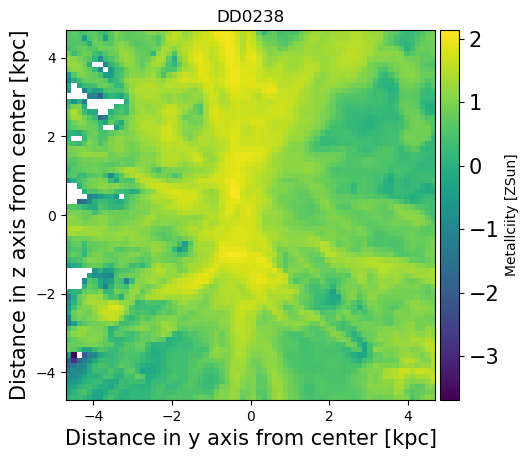

yt : [INFO     ] 2023-08-02 18:02:29,146 Parameters: current_time              = 104.81652781829
yt : [INFO     ] 2023-08-02 18:02:29,147 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-08-02 18:02:29,148 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-02 18:02:29,149 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-08-02 18:02:29,150 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-08-02 18:02:29,151 Parameters: current_redshift          = 2.9116806075987
yt : [INFO     ] 2023-08-02 18:02:29,151 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-08-02 18:02:29,152 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-08-02 18:02:29,153 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-08-02 18:02:29,154 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0287/DD0287
get_refine_box: using this location:     col1       col2     col3     col4     col5     col6     col7   col8
------------ -------- -------- -------- -------- -------- -------- ----
2.9116806076 0.493954 0.490721 0.500203 0.495954 0.492721 0.502203    9


Parsing Hierarchy : 100%|█████████████████| 7384/7384 [00:00<00:00, 9343.51it/s]
yt : [INFO     ] 2023-08-02 18:02:30,249 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-08-02 18:04:58,078 Projection completed
yt : [INFO     ] 2023-08-02 18:04:58,079 Making a fixed resolution buffer of (('gas', 'metallicity')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


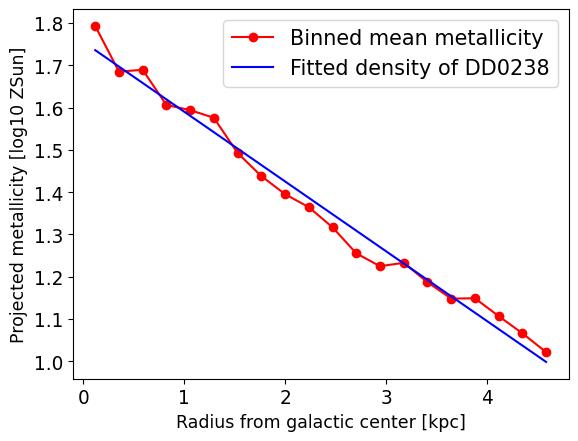

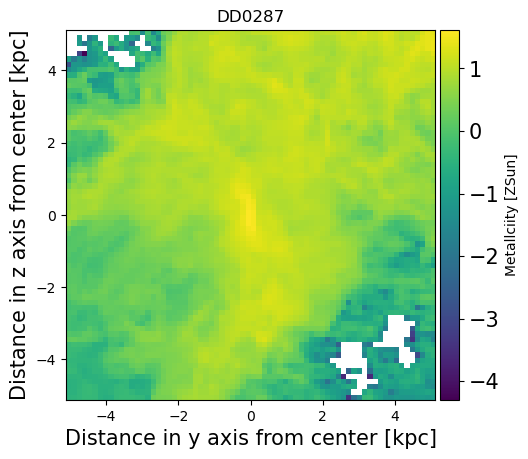

yt : [INFO     ] 2023-08-02 18:04:58,648 Parameters: current_time              = 106.31652781829
yt : [INFO     ] 2023-08-02 18:04:58,648 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-08-02 18:04:58,649 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-02 18:04:58,650 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-08-02 18:04:58,651 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-08-02 18:04:58,652 Parameters: current_redshift          = 2.8742891413864
yt : [INFO     ] 2023-08-02 18:04:58,653 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-08-02 18:04:58,654 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-08-02 18:04:58,654 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-08-02 18:04:58,655 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0293/DD0293
get_refine_box: using this location:      col1       col2     col3     col4    col5     col6     col7  col8
------------- -------- -------- ------- -------- -------- ------- ----
2.87428914139 0.493962 0.490687 0.50017 0.495962 0.492687 0.50217    9


Parsing Hierarchy : 100%|█████████████████| 7297/7297 [00:01<00:00, 4315.35it/s]
yt : [INFO     ] 2023-08-02 18:05:00,694 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-08-02 18:07:29,297 Projection completed
yt : [INFO     ] 2023-08-02 18:07:29,298 Making a fixed resolution buffer of (('gas', 'metallicity')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


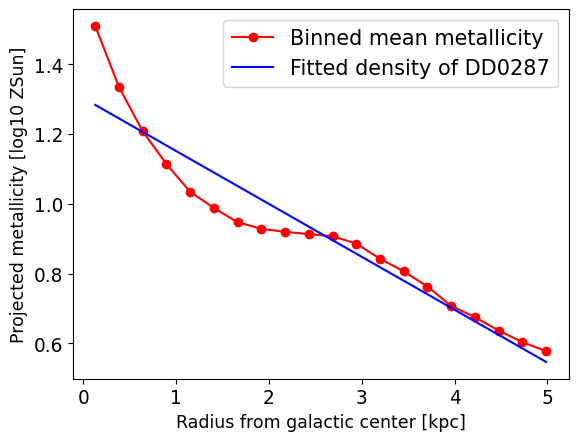

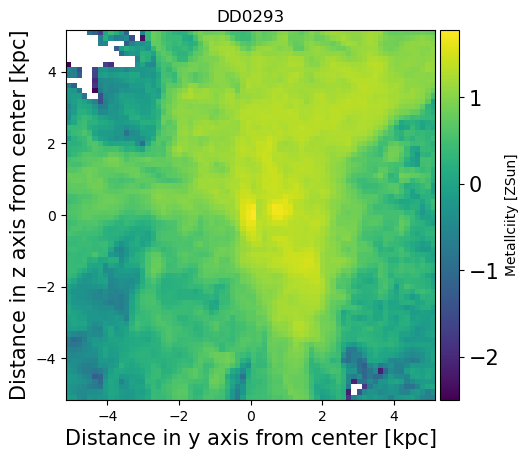

yt : [INFO     ] 2023-08-02 18:07:29,865 Parameters: current_time              = 117.56652781829
yt : [INFO     ] 2023-08-02 18:07:29,866 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-08-02 18:07:29,867 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-02 18:07:29,868 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-08-02 18:07:29,870 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-08-02 18:07:29,870 Parameters: current_redshift          = 2.6192132579666
yt : [INFO     ] 2023-08-02 18:07:29,871 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-08-02 18:07:29,872 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-08-02 18:07:29,872 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-08-02 18:07:29,873 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0338/DD0338
get_refine_box: using this location:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
2.61921325797 0.493773 0.490067 0.500353 0.495773 0.492067 0.502353    9


Parsing Hierarchy : 100%|█████████████████| 8624/8624 [00:00<00:00, 8851.36it/s]
yt : [INFO     ] 2023-08-02 18:07:31,151 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-08-02 18:10:38,132 Projection completed
yt : [INFO     ] 2023-08-02 18:10:38,133 Making a fixed resolution buffer of (('gas', 'metallicity')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


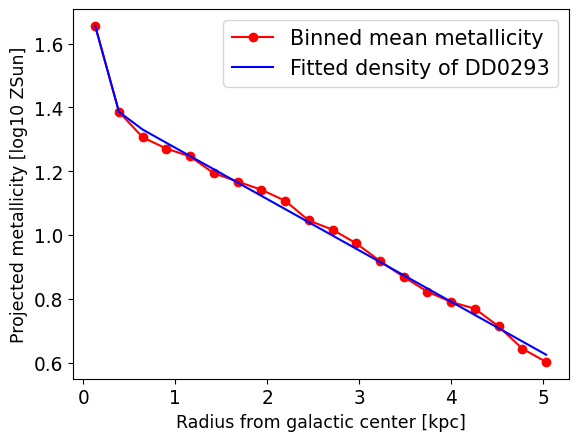

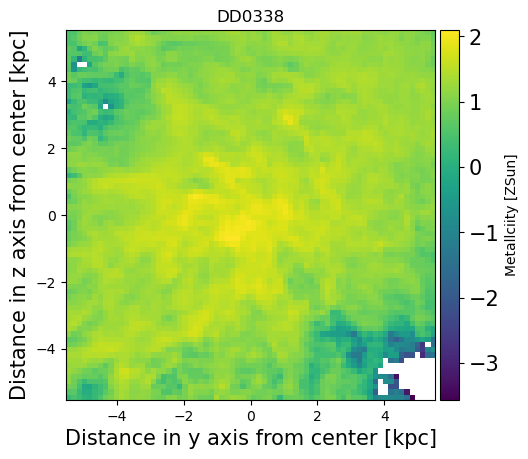

yt : [INFO     ] 2023-08-02 18:10:38,721 Parameters: current_time              = 142.56652781829
yt : [INFO     ] 2023-08-02 18:10:38,722 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-08-02 18:10:38,723 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-02 18:10:38,725 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-08-02 18:10:38,726 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-08-02 18:10:38,726 Parameters: current_redshift          = 2.174064272558
yt : [INFO     ] 2023-08-02 18:10:38,727 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-08-02 18:10:38,728 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-08-02 18:10:38,729 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-08-02 18:10:38,730 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0438/DD0438
get_refine_box: using this location:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
2.17406427256 0.493252 0.488579 0.500941 0.495252 0.490579 0.502941    9


Parsing Hierarchy : 100%|████████████████| 9619/9619 [00:00<00:00, 10649.68it/s]
yt : [INFO     ] 2023-08-02 18:10:39,958 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-08-02 18:13:52,035 Projection completed
yt : [INFO     ] 2023-08-02 18:13:52,036 Making a fixed resolution buffer of (('gas', 'metallicity')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


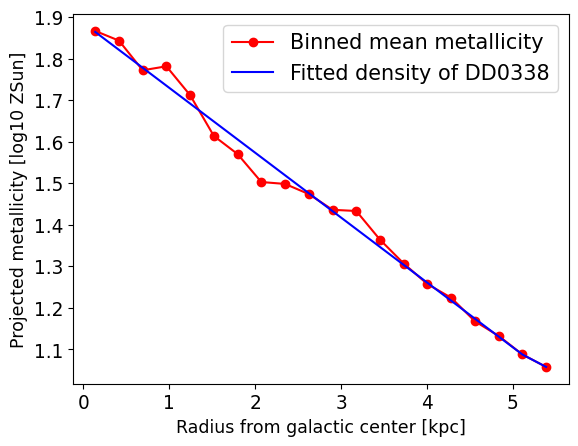

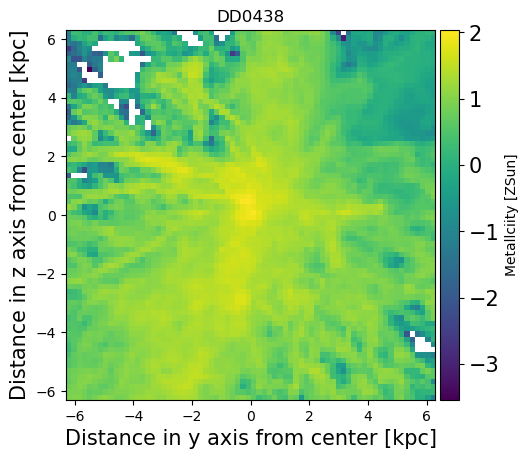

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0538/DD0538


yt : [INFO     ] 2023-08-02 18:13:52,861 Parameters: current_time              = 167.56652781829
yt : [INFO     ] 2023-08-02 18:13:52,862 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-08-02 18:13:52,863 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-02 18:13:52,864 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-08-02 18:13:52,865 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-08-02 18:13:52,865 Parameters: current_redshift          = 1.8407728906142
yt : [INFO     ] 2023-08-02 18:13:52,866 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-08-02 18:13:52,867 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-08-02 18:13:52,868 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-08-02 18:13:52,869 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
1.84077289061 0.492796 0.487204 0.501442 0.494796 0.489204 0.503442    9


Parsing Hierarchy : 100%|█████████████████| 6003/6003 [00:01<00:00, 5620.79it/s]
yt : [INFO     ] 2023-08-02 18:13:54,191 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-08-02 18:16:03,079 Projection completed
yt : [INFO     ] 2023-08-02 18:16:03,081 Making a fixed resolution buffer of (('gas', 'metallicity')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


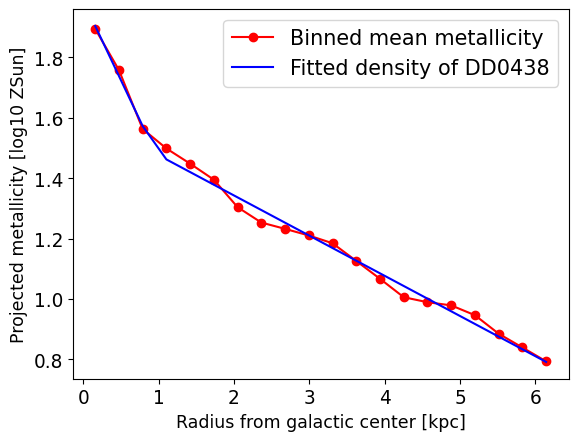

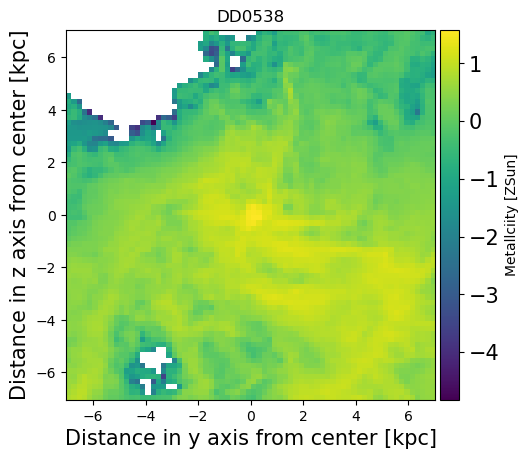

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0638/DD0638


yt : [INFO     ] 2023-08-02 18:16:03,863 Parameters: current_time              = 192.56652781829
yt : [INFO     ] 2023-08-02 18:16:03,864 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-08-02 18:16:03,865 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-02 18:16:03,866 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-08-02 18:16:03,867 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-08-02 18:16:03,867 Parameters: current_redshift          = 1.5796008591072
yt : [INFO     ] 2023-08-02 18:16:03,868 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-08-02 18:16:03,869 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-08-02 18:16:03,870 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-08-02 18:16:03,870 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:      col1       col2    col3     col4     col5    col6     col7   col8
------------- ------- -------- -------- ------- -------- -------- ----
1.57960085911 0.49248 0.485831 0.501973 0.49448 0.487831 0.503973    9


Parsing Hierarchy : 100%|█████████████████| 7363/7363 [00:01<00:00, 3923.38it/s]
yt : [INFO     ] 2023-08-02 18:16:06,068 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-08-02 18:18:33,921 Projection completed
yt : [INFO     ] 2023-08-02 18:18:33,923 Making a fixed resolution buffer of (('gas', 'metallicity')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


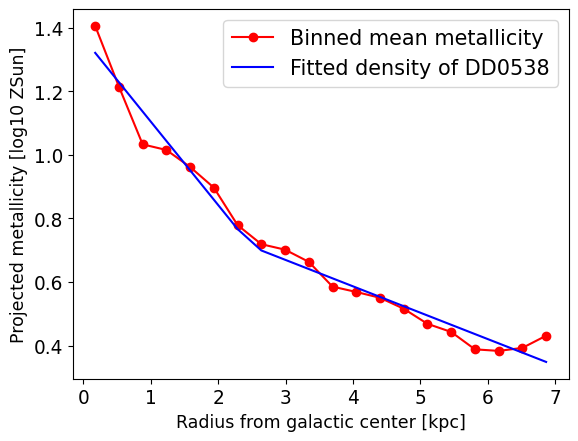

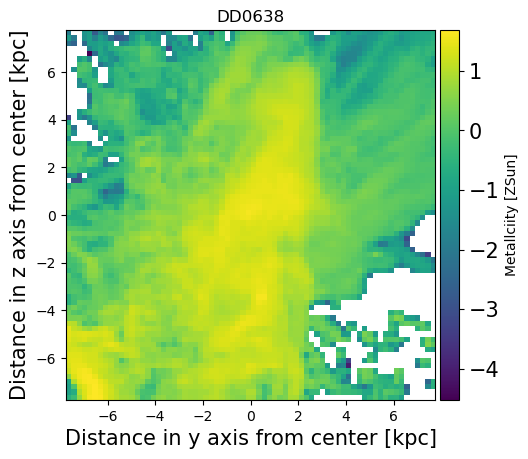

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0738/DD0738


yt : [INFO     ] 2023-08-02 18:18:35,145 Parameters: current_time              = 217.56652781829
yt : [INFO     ] 2023-08-02 18:18:35,146 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-08-02 18:18:35,147 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-02 18:18:35,149 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-08-02 18:18:35,150 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-08-02 18:18:35,151 Parameters: current_redshift          = 1.3679320867642
yt : [INFO     ] 2023-08-02 18:18:35,152 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-08-02 18:18:35,153 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-08-02 18:18:35,154 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-08-02 18:18:35,155 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:      col1       col2    col3     col4    col5    col6     col7  col8
------------- ------- -------- ------- ------- -------- ------- ----
1.36793208676 0.49219 0.484532 0.50256 0.49419 0.486532 0.50456    9


Parsing Hierarchy : 100%|█████████████████| 8207/8207 [00:01<00:00, 4559.30it/s]
yt : [INFO     ] 2023-08-02 18:18:38,006 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-08-02 18:21:21,020 Projection completed
yt : [INFO     ] 2023-08-02 18:21:21,021 Making a fixed resolution buffer of (('gas', 'metallicity')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


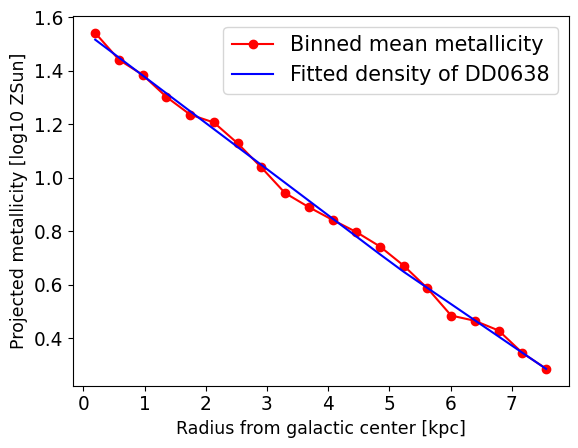

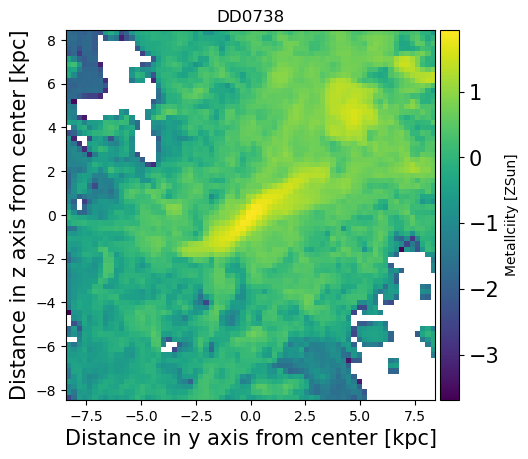

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0838/DD0838


yt : [INFO     ] 2023-08-02 18:21:21,843 Parameters: current_time              = 242.56652781829
yt : [INFO     ] 2023-08-02 18:21:21,844 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-08-02 18:21:21,845 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-02 18:21:21,846 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-08-02 18:21:21,847 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-08-02 18:21:21,848 Parameters: current_redshift          = 1.1918720434881
yt : [INFO     ] 2023-08-02 18:21:21,849 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-08-02 18:21:21,849 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-08-02 18:21:21,850 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-08-02 18:21:21,851 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:      col1       col2    col3     col4     col5    col6     col7   col8
------------- ------- -------- -------- ------- -------- -------- ----
1.19187204349 0.49185 0.483393 0.503033 0.49385 0.485393 0.505033    9


Parsing Hierarchy : 100%|█████████████████| 6414/6414 [00:00<00:00, 7343.60it/s]
yt : [INFO     ] 2023-08-02 18:21:23,016 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-08-02 18:23:36,145 Projection completed
yt : [INFO     ] 2023-08-02 18:23:36,147 Making a fixed resolution buffer of (('gas', 'metallicity')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


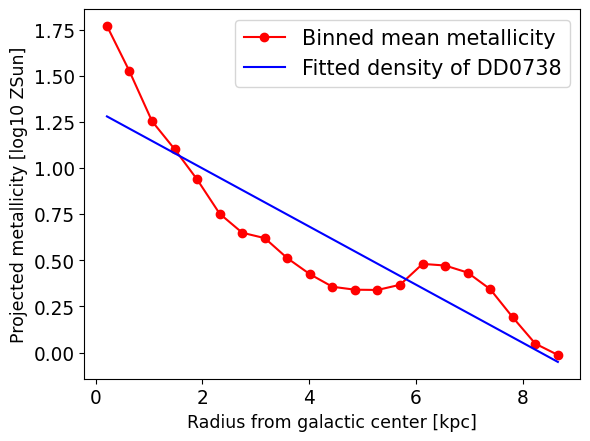

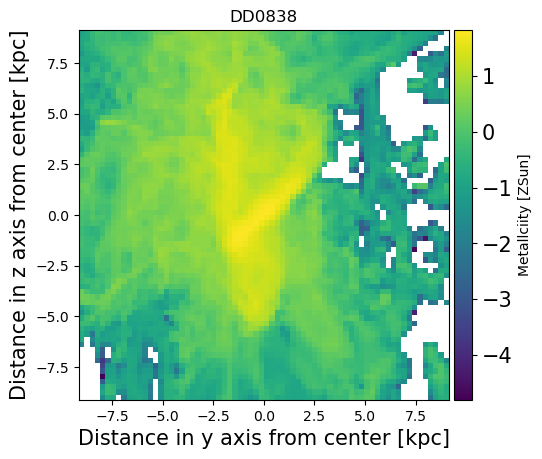

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0938/DD0938


yt : [INFO     ] 2023-08-02 18:23:36,904 Parameters: current_time              = 267.56652781829
yt : [INFO     ] 2023-08-02 18:23:36,905 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-08-02 18:23:36,906 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-02 18:23:36,907 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-08-02 18:23:36,908 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-08-02 18:23:36,909 Parameters: current_redshift          = 1.0423765498971
yt : [INFO     ] 2023-08-02 18:23:36,910 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-08-02 18:23:36,911 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-08-02 18:23:36,912 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-08-02 18:23:36,912 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:     col1       col2     col3     col4     col5     col6     col7   col8
------------ -------- -------- -------- -------- -------- -------- ----
1.0423765499 0.491558 0.482256 0.503483 0.493558 0.484256 0.505483    9


Parsing Hierarchy : 100%|█████████████████| 6646/6646 [00:01<00:00, 5890.02it/s]
yt : [INFO     ] 2023-08-02 18:23:38,316 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-08-02 18:25:51,593 Projection completed
yt : [INFO     ] 2023-08-02 18:25:51,594 Making a fixed resolution buffer of (('gas', 'metallicity')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


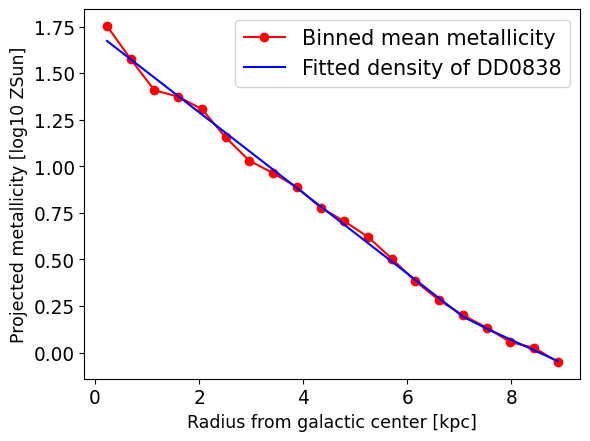

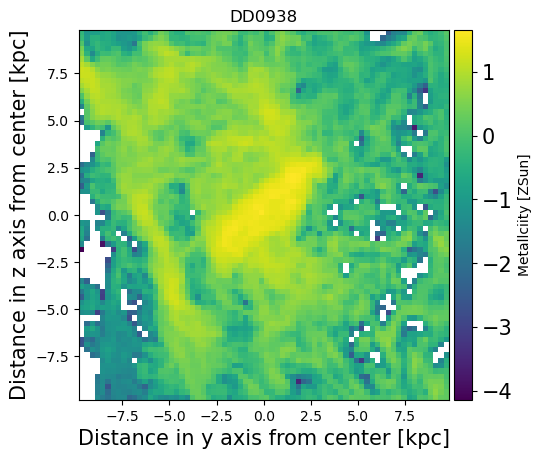

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1038/DD1038


yt : [INFO     ] 2023-08-02 18:25:52,414 Parameters: current_time              = 292.31652781829
yt : [INFO     ] 2023-08-02 18:25:52,416 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-08-02 18:25:52,417 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-02 18:25:52,418 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-08-02 18:25:52,419 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-08-02 18:25:52,420 Parameters: current_redshift          = 0.91449134314195
yt : [INFO     ] 2023-08-02 18:25:52,421 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-08-02 18:25:52,422 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-08-02 18:25:52,423 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-08-02 18:25:52,423 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:      col1        col2     col3     col4     col5     col6     col7   col8
-------------- -------- -------- -------- -------- -------- -------- ----
0.914491343142 0.491324 0.481173 0.503918 0.493324 0.483173 0.505918    9


Parsing Hierarchy : 100%|█████████████████| 5369/5369 [00:01<00:00, 3917.51it/s]
yt : [INFO     ] 2023-08-02 18:25:54,009 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-08-02 18:27:46,498 Projection completed
yt : [INFO     ] 2023-08-02 18:27:46,499 Making a fixed resolution buffer of (('gas', 'metallicity')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


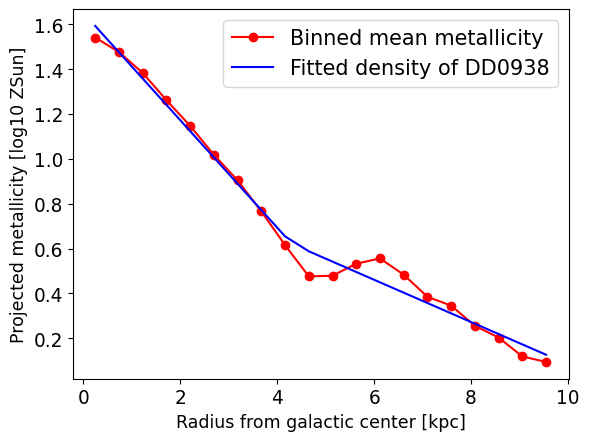

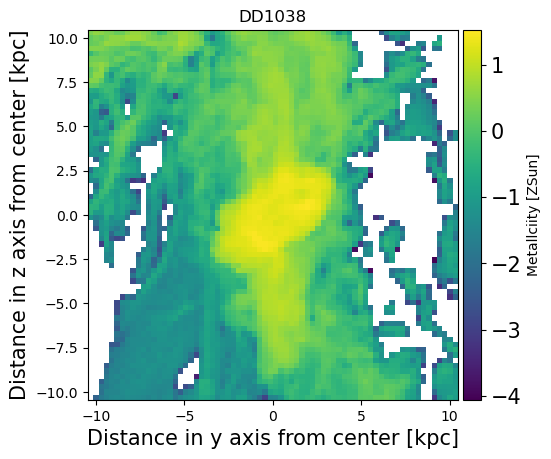

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1138/DD1138


yt : [INFO     ] 2023-08-02 18:27:47,281 Parameters: current_time              = 317.31652781829
yt : [INFO     ] 2023-08-02 18:27:47,281 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-08-02 18:27:47,282 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-02 18:27:47,283 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-08-02 18:27:47,284 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-08-02 18:27:47,285 Parameters: current_redshift          = 0.80131183964773
yt : [INFO     ] 2023-08-02 18:27:47,286 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-08-02 18:27:47,287 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-08-02 18:27:47,288 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-08-02 18:27:47,288 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2    col3    col4     col5    col6    col7   col8
---------------- ------- ------- -------- ------- ------- -------- ----
0.80131183964773 0.49111 0.48016 0.504261 0.49311 0.48216 0.506261    9


Parsing Hierarchy : 100%|█████████████████| 5629/5629 [00:00<00:00, 7246.35it/s]
yt : [INFO     ] 2023-08-02 18:27:48,305 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-08-02 18:29:43,662 Projection completed
yt : [INFO     ] 2023-08-02 18:29:43,663 Making a fixed resolution buffer of (('gas', 'metallicity')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


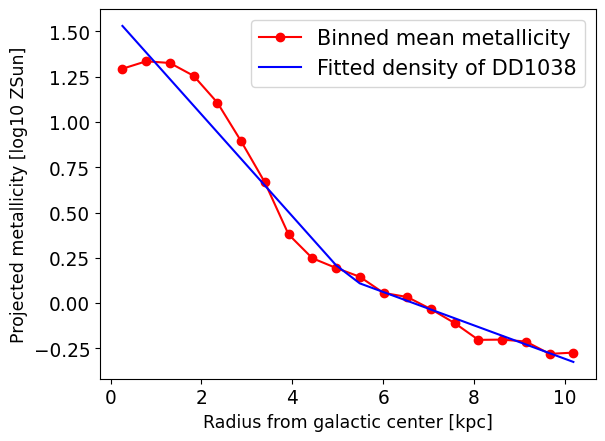

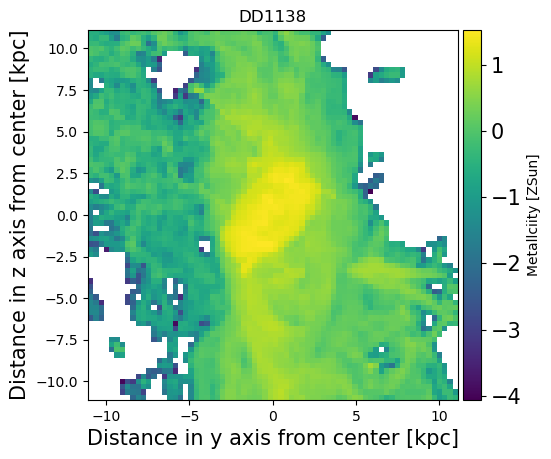

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1238/DD1238


yt : [INFO     ] 2023-08-02 18:29:44,530 Parameters: current_time              = 342.31652781829
yt : [INFO     ] 2023-08-02 18:29:44,531 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-08-02 18:29:44,532 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-02 18:29:44,533 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-08-02 18:29:44,535 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-08-02 18:29:44,536 Parameters: current_redshift          = 0.70104740107777
yt : [INFO     ] 2023-08-02 18:29:44,536 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-08-02 18:29:44,537 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-08-02 18:29:44,538 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-08-02 18:29:44,538 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2    col3     col4     col5    col6     col7   col8
---------------- ------- -------- -------- ------- -------- -------- ----
0.70104740107777 0.49091 0.479176 0.504679 0.49291 0.481176 0.506679    9


Parsing Hierarchy : 100%|█████████████████| 6009/6009 [00:01<00:00, 5992.74it/s]
yt : [INFO     ] 2023-08-02 18:29:45,825 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-08-02 18:31:45,683 Projection completed
yt : [INFO     ] 2023-08-02 18:31:45,685 Making a fixed resolution buffer of (('gas', 'metallicity')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


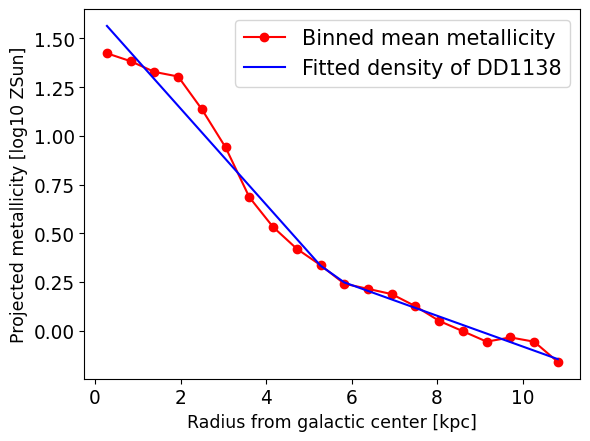

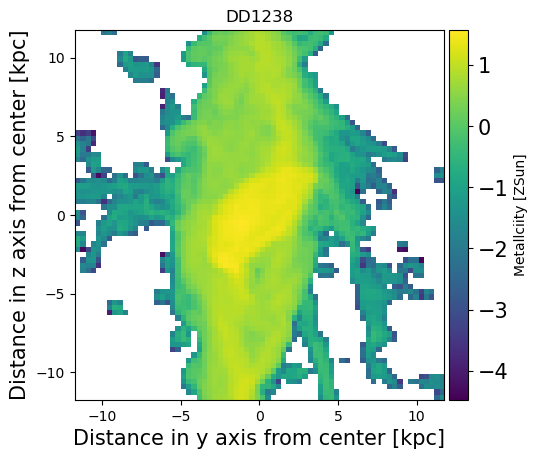

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1338/DD1338


yt : [INFO     ] 2023-08-02 18:31:46,462 Parameters: current_time              = 367.31652781829
yt : [INFO     ] 2023-08-02 18:31:46,463 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-08-02 18:31:46,464 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-02 18:31:46,466 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-08-02 18:31:46,467 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-08-02 18:31:46,467 Parameters: current_redshift          = 0.61132831909135
yt : [INFO     ] 2023-08-02 18:31:46,468 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-08-02 18:31:46,469 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-08-02 18:31:46,469 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-08-02 18:31:46,470 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3    col4     col5     col6    col7   col8
---------------- -------- ------- -------- -------- ------- -------- ----
0.61132831909135 0.490681 0.47823 0.505093 0.492681 0.48023 0.507093    9


Parsing Hierarchy : 100%|█████████████████| 6366/6366 [00:00<00:00, 7465.94it/s]
yt : [INFO     ] 2023-08-02 18:31:47,625 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-08-02 18:33:53,049 Projection completed
yt : [INFO     ] 2023-08-02 18:33:53,051 Making a fixed resolution buffer of (('gas', 'metallicity')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


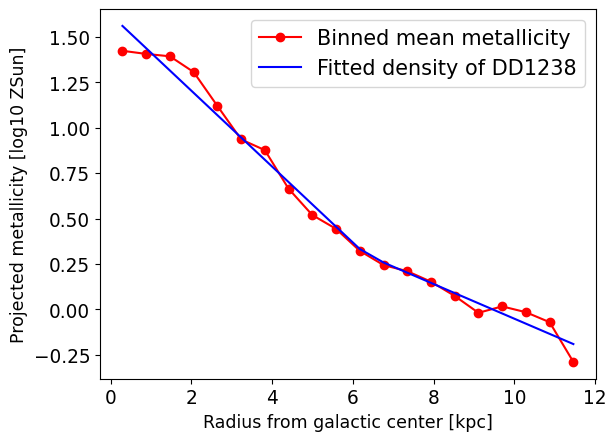

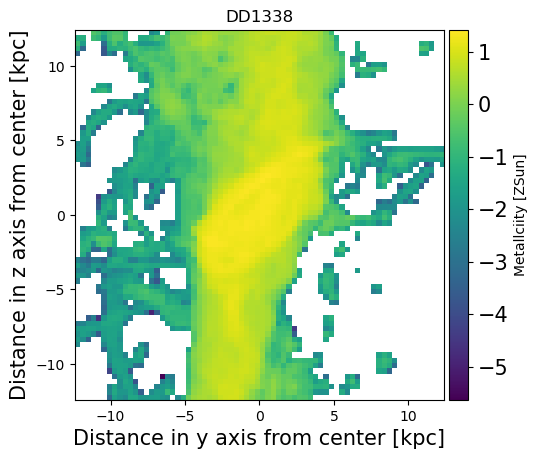

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1438/DD1438


yt : [INFO     ] 2023-08-02 18:33:53,874 Parameters: current_time              = 392.31652781829
yt : [INFO     ] 2023-08-02 18:33:53,875 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-08-02 18:33:53,876 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-02 18:33:53,877 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-08-02 18:33:53,878 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-08-02 18:33:53,879 Parameters: current_redshift          = 0.53034842583426
yt : [INFO     ] 2023-08-02 18:33:53,880 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-08-02 18:33:53,881 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-08-02 18:33:53,882 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-08-02 18:33:53,882 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.53034842583426 0.490464 0.477354 0.505497 0.492464 0.479354 0.507497    9


Parsing Hierarchy : 100%|█████████████████| 6029/6029 [00:01<00:00, 5944.70it/s]
yt : [INFO     ] 2023-08-02 18:33:55,137 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-08-02 18:35:54,511 Projection completed
yt : [INFO     ] 2023-08-02 18:35:54,513 Making a fixed resolution buffer of (('gas', 'metallicity')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


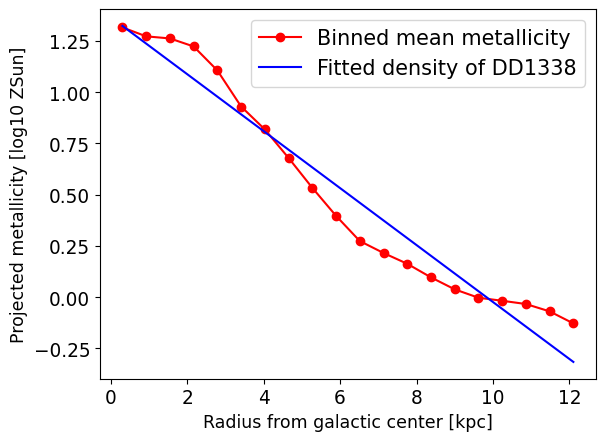

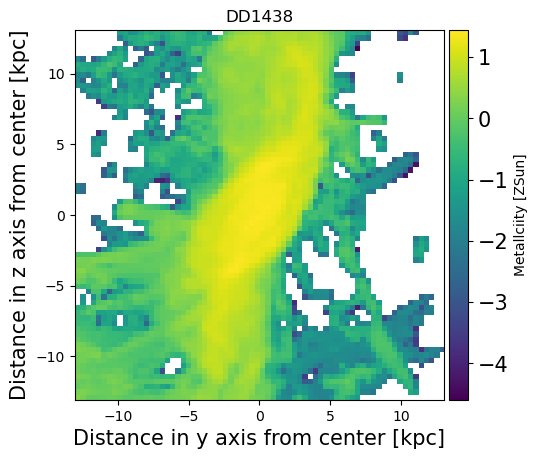

yt : [INFO     ] 2023-08-02 18:35:55,677 Parameters: current_time              = 402.06652781829
yt : [INFO     ] 2023-08-02 18:35:55,678 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-08-02 18:35:55,679 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-02 18:35:55,680 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-08-02 18:35:55,681 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-08-02 18:35:55,682 Parameters: current_redshift          = 0.50082158855578
yt : [INFO     ] 2023-08-02 18:35:55,683 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-08-02 18:35:55,683 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-08-02 18:35:55,684 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-08-02 18:35:55,685 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1477/DD1477
get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.50082158855578 0.490382 0.477019 0.505663 0.492382 0.479019 0.507663    9


Parsing Hierarchy : 100%|█████████████████| 6066/6066 [00:01<00:00, 4734.10it/s]
yt : [INFO     ] 2023-08-02 18:35:57,245 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-08-02 18:38:07,670 Projection completed
yt : [INFO     ] 2023-08-02 18:38:07,671 Making a fixed resolution buffer of (('gas', 'metallicity')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


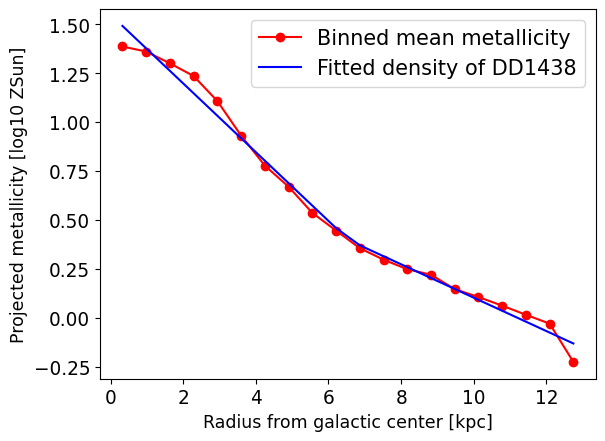

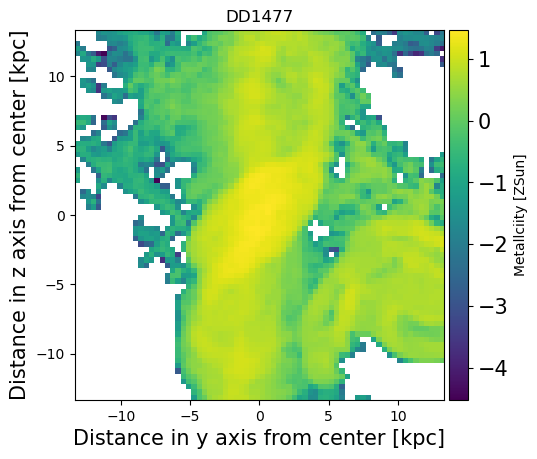

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1478/DD1478


yt : [INFO     ] 2023-08-02 18:38:08,440 Parameters: current_time              = 402.31652781829
yt : [INFO     ] 2023-08-02 18:38:08,441 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-08-02 18:38:08,442 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-02 18:38:08,443 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-08-02 18:38:08,444 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-08-02 18:38:08,445 Parameters: current_redshift          = 0.50007848881181
yt : [INFO     ] 2023-08-02 18:38:08,446 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-08-02 18:38:08,447 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-08-02 18:38:08,448 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-08-02 18:38:08,448 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2    col3     col4     col5    col6     col7   col8
---------------- ------- -------- -------- ------- -------- -------- ----
0.50007848881181 0.49038 0.477011 0.505667 0.49238 0.479011 0.507667    9


Parsing Hierarchy : 100%|█████████████████| 5947/5947 [00:00<00:00, 6876.86it/s]
yt : [INFO     ] 2023-08-02 18:38:09,574 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-08-02 18:40:17,832 Projection completed
yt : [INFO     ] 2023-08-02 18:40:17,834 Making a fixed resolution buffer of (('gas', 'metallicity')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


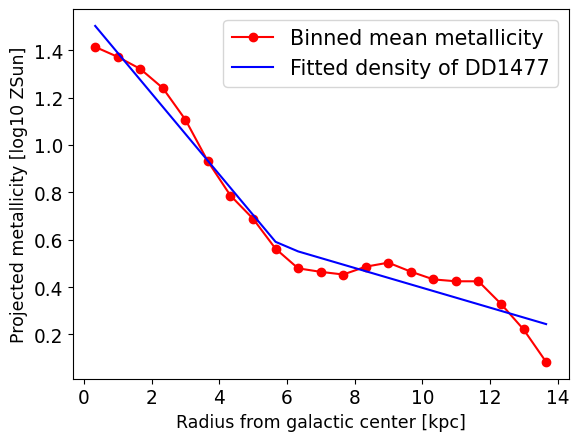

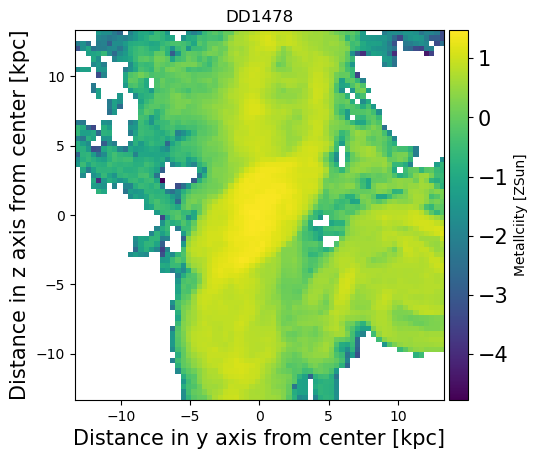

yt : [INFO     ] 2023-08-02 18:40:18,677 Parameters: current_time              = 402.56652517609
yt : [INFO     ] 2023-08-02 18:40:18,677 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-08-02 18:40:18,678 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-02 18:40:18,679 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-08-02 18:40:18,679 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-08-02 18:40:18,680 Parameters: current_redshift          = 0.49933608114367
yt : [INFO     ] 2023-08-02 18:40:18,681 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-08-02 18:40:18,681 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-08-02 18:40:18,682 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-08-02 18:40:18,683 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1479/DD1479
get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.49933608114367 0.490378 0.477002 0.505671 0.492378 0.479002 0.507671    9


Parsing Hierarchy : 100%|█████████████████| 5985/5985 [00:01<00:00, 5200.29it/s]
yt : [INFO     ] 2023-08-02 18:40:20,092 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-08-02 18:42:27,266 Projection completed
yt : [INFO     ] 2023-08-02 18:42:27,268 Making a fixed resolution buffer of (('gas', 'metallicity')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


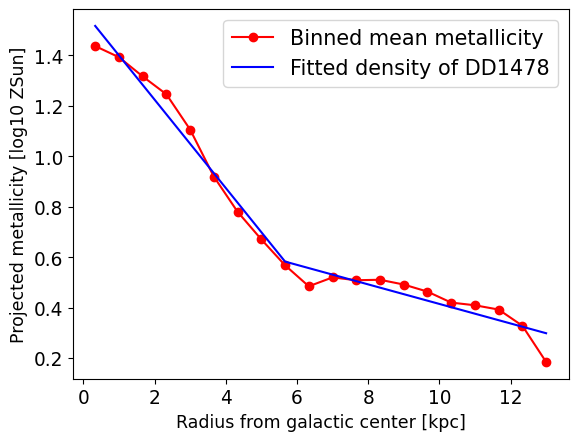

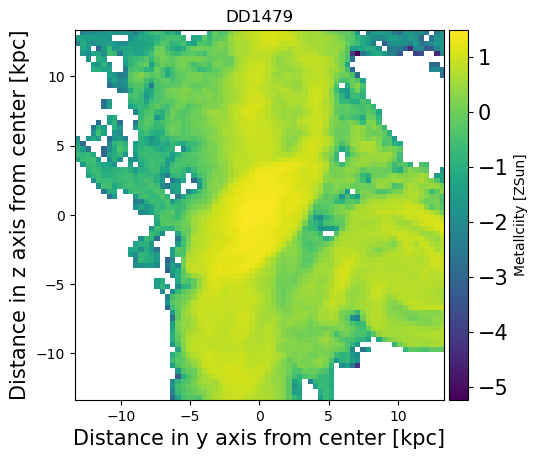

yt : [INFO     ] 2023-08-02 18:42:28,009 Parameters: current_time              = 417.31652781829
yt : [INFO     ] 2023-08-02 18:42:28,010 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-08-02 18:42:28,011 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-02 18:42:28,012 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-08-02 18:42:28,013 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-08-02 18:42:28,013 Parameters: current_redshift          = 0.45670560906839
yt : [INFO     ] 2023-08-02 18:42:28,014 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-08-02 18:42:28,015 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-08-02 18:42:28,016 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-08-02 18:42:28,016 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1538/DD1538
get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.45670560906839 0.490252 0.476517 0.505875 0.492252 0.478517 0.507875    9


Parsing Hierarchy : 100%|█████████████████| 6119/6119 [00:00<00:00, 7599.85it/s]
yt : [INFO     ] 2023-08-02 18:42:29,074 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-08-02 18:44:31,596 Projection completed
yt : [INFO     ] 2023-08-02 18:44:31,598 Making a fixed resolution buffer of (('gas', 'metallicity')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


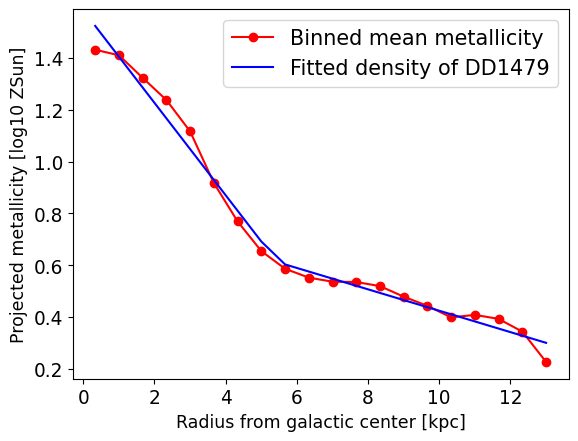

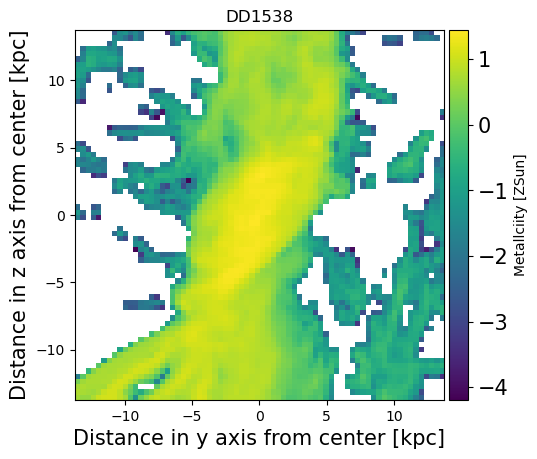

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1638/DD1638


yt : [INFO     ] 2023-08-02 18:44:32,529 Parameters: current_time              = 442.31652781829
yt : [INFO     ] 2023-08-02 18:44:32,530 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-08-02 18:44:32,531 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-02 18:44:32,532 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-08-02 18:44:32,533 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-08-02 18:44:32,534 Parameters: current_redshift          = 0.3892837031507
yt : [INFO     ] 2023-08-02 18:44:32,535 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-08-02 18:44:32,536 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-08-02 18:44:32,536 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-08-02 18:44:32,537 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.38929394169243 0.490071 0.475697 0.506226 0.492071 0.477697 0.508226    9


Parsing Hierarchy : 100%|█████████████████| 5613/5613 [00:01<00:00, 4241.03it/s]
yt : [INFO     ] 2023-08-02 18:44:34,132 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-08-02 18:46:26,957 Projection completed
yt : [INFO     ] 2023-08-02 18:46:26,959 Making a fixed resolution buffer of (('gas', 'metallicity')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


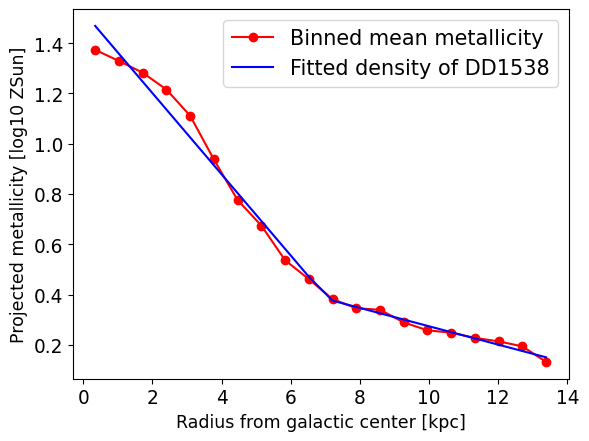

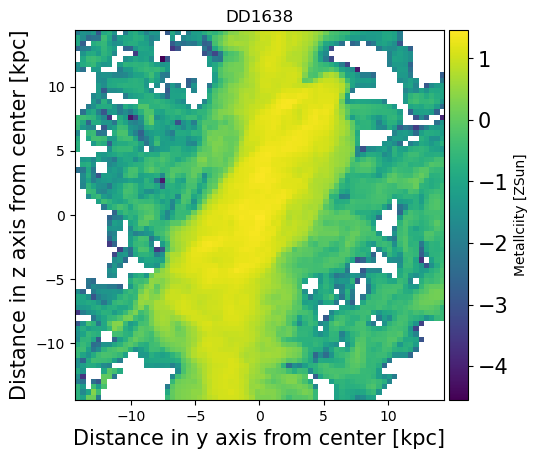

yt : [INFO     ] 2023-08-02 18:46:27,637 Parameters: current_time              = 467.31652781829
yt : [INFO     ] 2023-08-02 18:46:27,638 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-08-02 18:46:27,639 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-02 18:46:27,640 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-08-02 18:46:27,641 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-08-02 18:46:27,642 Parameters: current_redshift          = 0.32721407621449
yt : [INFO     ] 2023-08-02 18:46:27,643 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-08-02 18:46:27,643 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-08-02 18:46:27,644 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-08-02 18:46:27,645 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1738/DD1738
get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.32722883488872 0.489878 0.474896 0.506564 0.491878 0.476896 0.508564    9


Parsing Hierarchy : 100%|█████████████████| 5309/5309 [00:00<00:00, 6762.24it/s]
yt : [INFO     ] 2023-08-02 18:46:28,721 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-08-02 18:48:16,042 Projection completed
yt : [INFO     ] 2023-08-02 18:48:16,043 Making a fixed resolution buffer of (('gas', 'metallicity')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


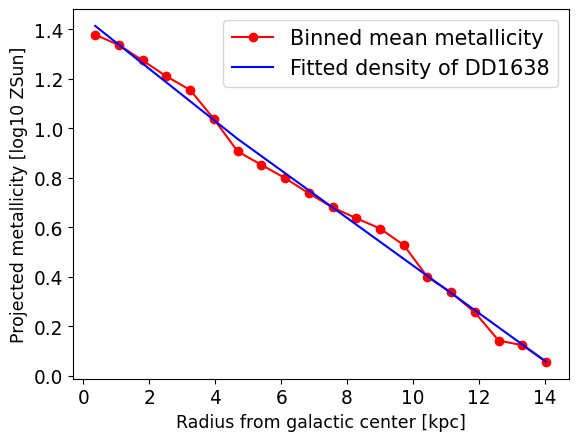

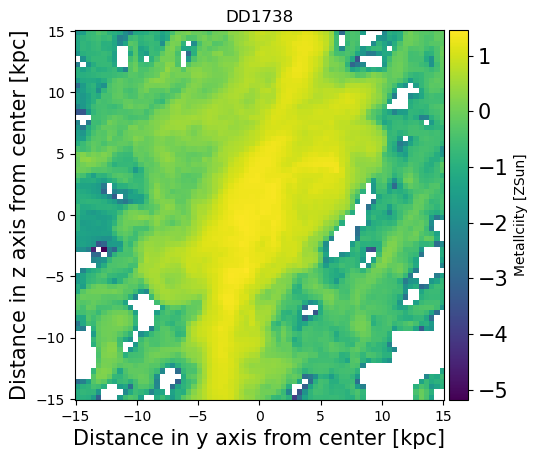

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1838/DD1838


yt : [INFO     ] 2023-08-02 18:48:16,976 Parameters: current_time              = 492.31652781829
yt : [INFO     ] 2023-08-02 18:48:16,977 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-08-02 18:48:16,978 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-02 18:48:16,979 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-08-02 18:48:16,980 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-08-02 18:48:16,981 Parameters: current_redshift          = 0.26978215732692
yt : [INFO     ] 2023-08-02 18:48:16,982 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-08-02 18:48:16,983 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-08-02 18:48:16,983 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-08-02 18:48:16,984 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1        col2     col3     col4     col5     col6     col7   col8
--------------- -------- -------- -------- -------- -------- -------- ----
0.2697939304999 0.489703 0.474121 0.506863 0.491703 0.476121 0.508863    9


Parsing Hierarchy : 100%|█████████████████| 5365/5365 [00:00<00:00, 5814.55it/s]
yt : [INFO     ] 2023-08-02 18:48:18,128 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-08-02 18:50:07,383 Projection completed
yt : [INFO     ] 2023-08-02 18:50:07,385 Making a fixed resolution buffer of (('gas', 'metallicity')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


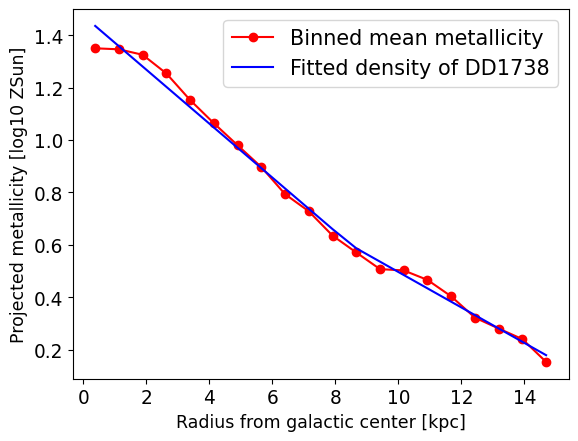

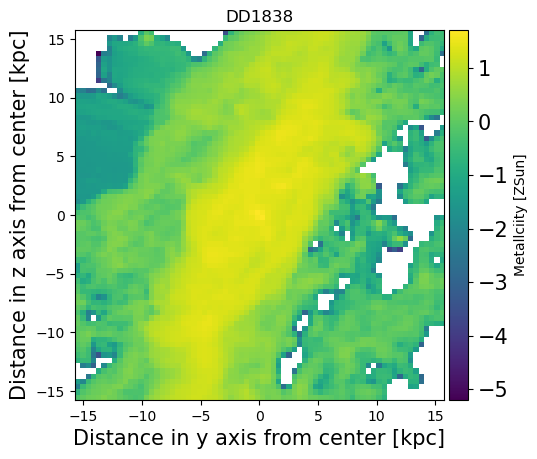

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1938/DD1938


yt : [INFO     ] 2023-08-02 18:50:08,166 Parameters: current_time              = 517.31652781829
yt : [INFO     ] 2023-08-02 18:50:08,167 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-08-02 18:50:08,168 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-02 18:50:08,169 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-08-02 18:50:08,170 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-08-02 18:50:08,172 Parameters: current_redshift          = 0.21639444449422
yt : [INFO     ] 2023-08-02 18:50:08,173 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-08-02 18:50:08,174 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-08-02 18:50:08,175 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-08-02 18:50:08,175 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.21640266677445 0.489548 0.473393 0.507161 0.491548 0.475393 0.509161    9


Parsing Hierarchy : 100%|█████████████████| 4944/4944 [00:00<00:00, 6031.55it/s]
yt : [INFO     ] 2023-08-02 18:50:09,226 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-08-02 18:51:50,672 Projection completed
yt : [INFO     ] 2023-08-02 18:51:50,673 Making a fixed resolution buffer of (('gas', 'metallicity')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


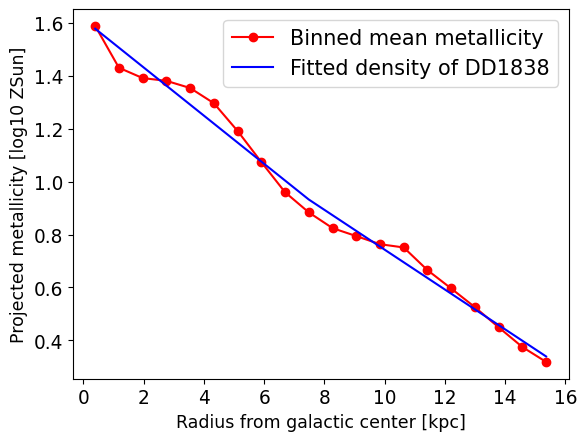

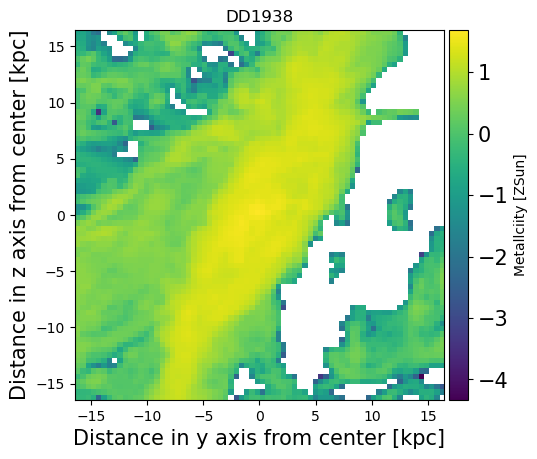

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2038/DD2038


yt : [INFO     ] 2023-08-02 18:51:51,591 Parameters: current_time              = 542.31652781829
yt : [INFO     ] 2023-08-02 18:51:51,592 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-08-02 18:51:51,593 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-02 18:51:51,594 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-08-02 18:51:51,595 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-08-02 18:51:51,595 Parameters: current_redshift          = 0.1665627895111
yt : [INFO     ] 2023-08-02 18:51:51,596 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-08-02 18:51:51,597 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-08-02 18:51:51,598 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-08-02 18:51:51,598 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.16656997024797 0.489403 0.472708 0.507468 0.491403 0.474708 0.509468    9


Parsing Hierarchy : 100%|█████████████████| 5224/5224 [00:00<00:00, 5725.99it/s]
yt : [INFO     ] 2023-08-02 18:51:52,801 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-08-02 18:53:35,083 Projection completed
yt : [INFO     ] 2023-08-02 18:53:35,086 Making a fixed resolution buffer of (('gas', 'metallicity')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


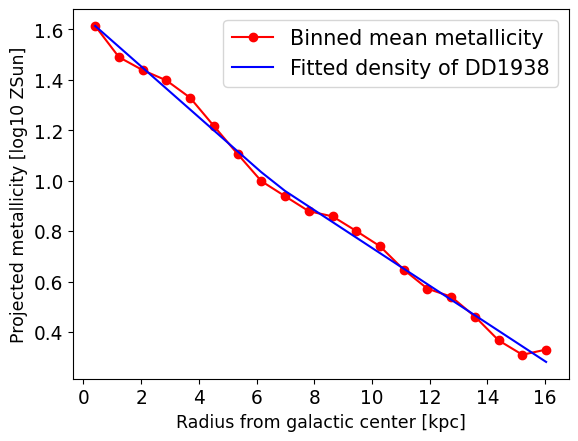

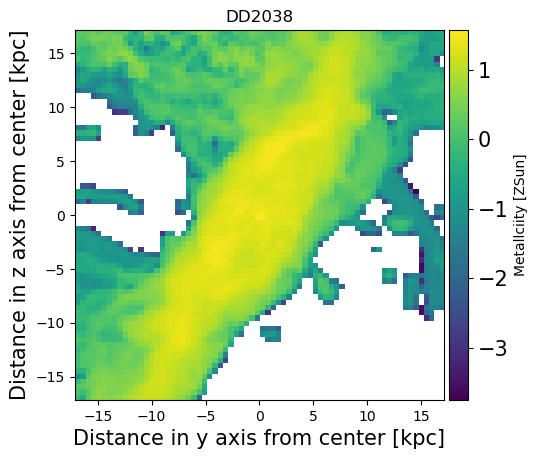

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2138/DD2138


yt : [INFO     ] 2023-08-02 18:53:35,963 Parameters: current_time              = 567.31652781829
yt : [INFO     ] 2023-08-02 18:53:35,964 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-08-02 18:53:35,964 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-02 18:53:35,965 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-08-02 18:53:35,966 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-08-02 18:53:35,967 Parameters: current_redshift          = 0.11988207020675
yt : [INFO     ] 2023-08-02 18:53:35,968 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-08-02 18:53:35,969 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-08-02 18:53:35,969 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-08-02 18:53:35,970 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.11989107535193 0.489254 0.472056 0.507771 0.491254 0.474056 0.509771    9


Parsing Hierarchy : 100%|█████████████████| 4682/4682 [00:00<00:00, 5718.53it/s]
yt : [INFO     ] 2023-08-02 18:53:37,021 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-08-02 18:55:12,505 Projection completed
yt : [INFO     ] 2023-08-02 18:55:12,506 Making a fixed resolution buffer of (('gas', 'metallicity')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


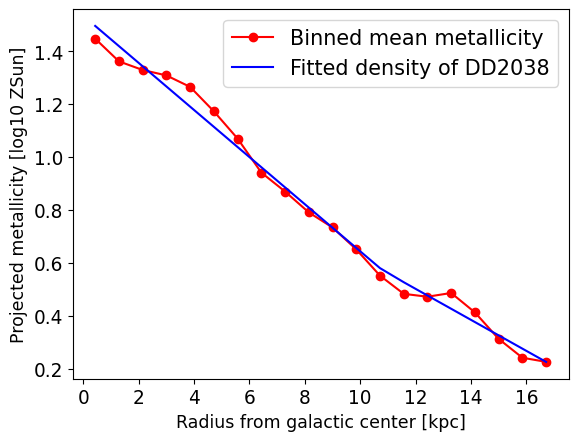

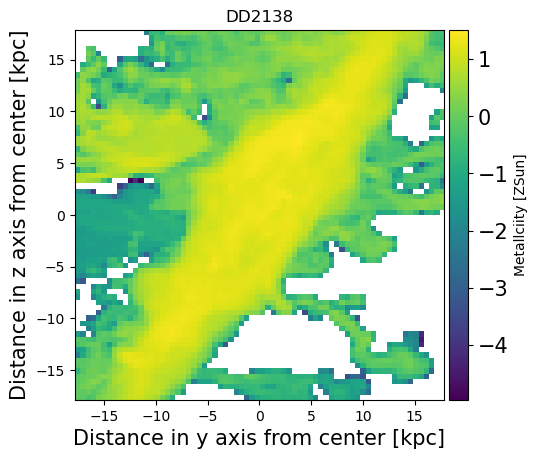

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2238/DD2238


yt : [INFO     ] 2023-08-02 18:55:13,393 Parameters: current_time              = 592.31652781829
yt : [INFO     ] 2023-08-02 18:55:13,394 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-08-02 18:55:13,394 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-02 18:55:13,396 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-08-02 18:55:13,397 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-08-02 18:55:13,397 Parameters: current_redshift          = 0.076013204837093
yt : [INFO     ] 2023-08-02 18:55:13,399 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-08-02 18:55:13,400 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-08-02 18:55:13,401 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-08-02 18:55:13,401 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:        col1         col2     col3     col4     col5     col6     col7   col8
----------------- -------- -------- -------- -------- -------- -------- ----
0.076025451160672 0.489123 0.471432 0.508053 0.491123 0.473432 0.510053    9


Parsing Hierarchy : 100%|█████████████████| 4688/4688 [00:00<00:00, 5025.16it/s]
yt : [INFO     ] 2023-08-02 18:55:14,581 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-08-02 18:56:49,074 Projection completed
yt : [INFO     ] 2023-08-02 18:56:49,075 Making a fixed resolution buffer of (('gas', 'metallicity')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


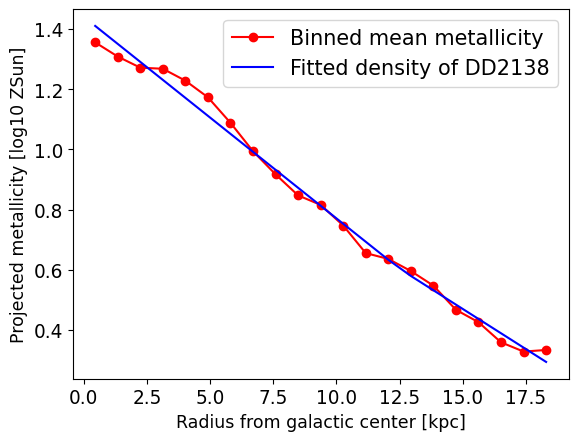

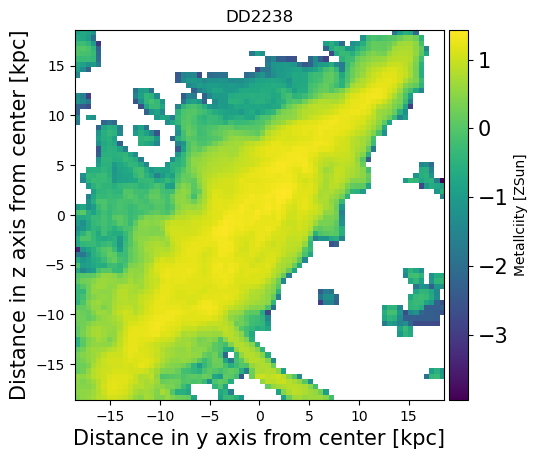

yt : [INFO     ] 2023-08-02 18:56:49,769 Parameters: current_time              = 604.81652781829
yt : [INFO     ] 2023-08-02 18:56:49,770 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-08-02 18:56:49,771 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-02 18:56:49,772 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-08-02 18:56:49,773 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-08-02 18:56:49,774 Parameters: current_redshift          = 0.055049291735707
yt : [INFO     ] 2023-08-02 18:56:49,775 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-08-02 18:56:49,775 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-08-02 18:56:49,776 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-08-02 18:56:49,777 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2288/DD2288
get_refine_box: using this location:        col1         col2     col3     col4     col5     col6     col7   col8
----------------- -------- -------- -------- -------- -------- -------- ----
0.055055663741937 0.489056 0.471131 0.508189 0.491056 0.473131 0.510189    9


Parsing Hierarchy : 100%|█████████████████| 4745/4745 [00:00<00:00, 6458.15it/s]
yt : [INFO     ] 2023-08-02 18:56:50,794 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-08-02 18:58:34,212 Projection completed
yt : [INFO     ] 2023-08-02 18:58:34,213 Making a fixed resolution buffer of (('gas', 'metallicity')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


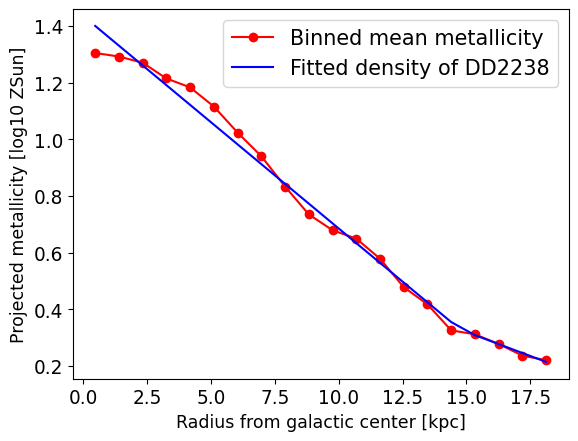

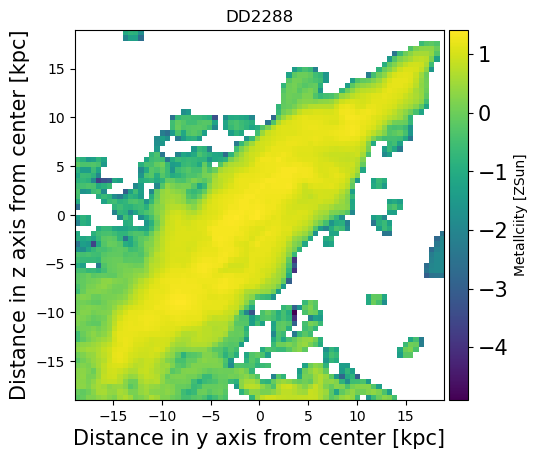

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2289/DD2289


yt : [INFO     ] 2023-08-02 18:58:35,221 Parameters: current_time              = 605.06652781829
yt : [INFO     ] 2023-08-02 18:58:35,222 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-08-02 18:58:35,223 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-02 18:58:35,224 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-08-02 18:58:35,225 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-08-02 18:58:35,226 Parameters: current_redshift          = 0.054634911934635
yt : [INFO     ] 2023-08-02 18:58:35,227 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-08-02 18:58:35,227 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-08-02 18:58:35,228 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-08-02 18:58:35,229 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:        col1         col2     col3     col4     col5     col6     col7   col8
----------------- -------- -------- -------- -------- -------- -------- ----
0.054642475638284 0.489054 0.471125 0.508191 0.491054 0.473125 0.510191    9


Parsing Hierarchy : 100%|█████████████████| 4798/4798 [00:00<00:00, 5474.92it/s]
yt : [INFO     ] 2023-08-02 18:58:36,368 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-08-02 19:00:19,774 Projection completed
yt : [INFO     ] 2023-08-02 19:00:19,775 Making a fixed resolution buffer of (('gas', 'metallicity')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


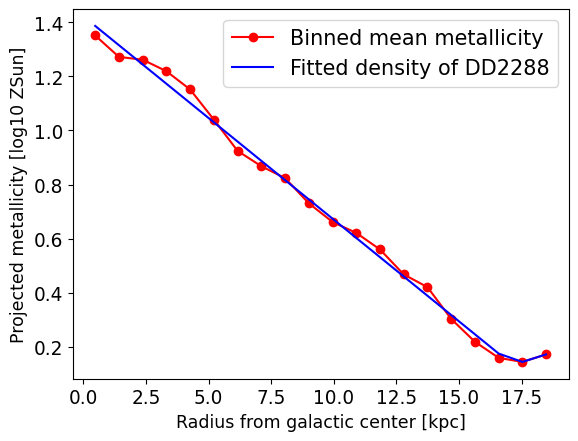

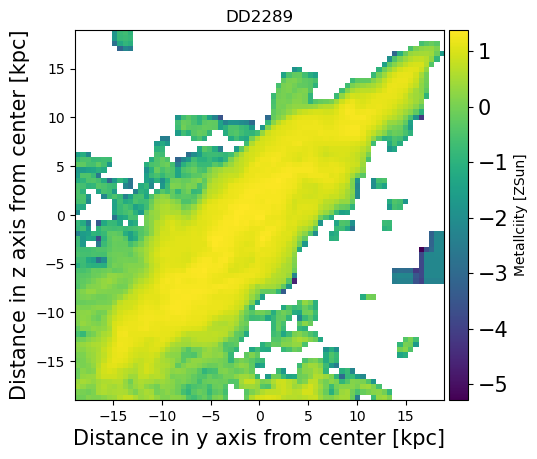

yt : [INFO     ] 2023-08-02 19:00:20,419 Parameters: current_time              = 617.31652781829
yt : [INFO     ] 2023-08-02 19:00:20,420 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-08-02 19:00:20,422 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-02 19:00:20,423 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-08-02 19:00:20,424 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-08-02 19:00:20,425 Parameters: current_redshift          = 0.034670076640073
yt : [INFO     ] 2023-08-02 19:00:20,426 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-08-02 19:00:20,427 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-08-02 19:00:20,427 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-08-02 19:00:20,428 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2338/DD2338
get_refine_box: using this location:        col1         col2     col3     col4    col5     col6     col7  col8
----------------- -------- -------- ------- -------- -------- ------- ----
0.034684446722936 0.488987 0.470833 0.50832 0.490987 0.472833 0.51032    9


Parsing Hierarchy : 100%|█████████████████| 4505/4505 [00:00<00:00, 5003.92it/s]
yt : [INFO     ] 2023-08-02 19:00:21,548 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-08-02 19:01:51,242 Projection completed
yt : [INFO     ] 2023-08-02 19:01:51,243 Making a fixed resolution buffer of (('gas', 'metallicity')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


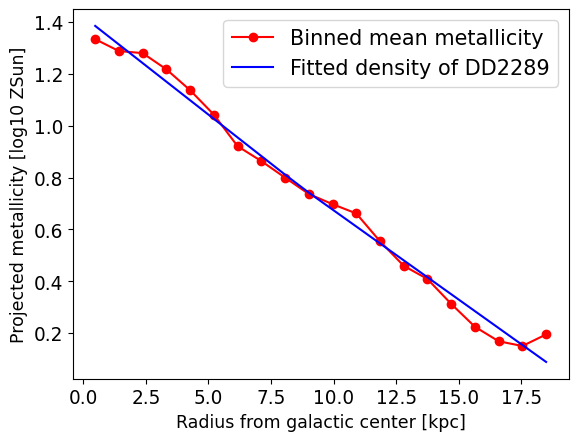

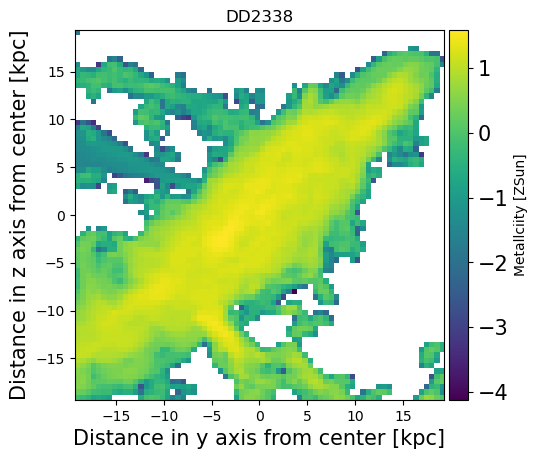

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2427/DD2427


yt : [INFO     ] 2023-08-02 19:01:52,146 Parameters: current_time              = 639.44480357087
yt : [INFO     ] 2023-08-02 19:01:52,147 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-08-02 19:01:52,148 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-02 19:01:52,149 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-08-02 19:01:52,150 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-08-02 19:01:52,150 Parameters: current_redshift          = 0
yt : [INFO     ] 2023-08-02 19:01:52,151 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-08-02 19:01:52,151 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-08-02 19:01:52,152 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-08-02 19:01:52,152 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:         col1          col2     col3     col4    col5     col6     col7  col8
------------------- -------- -------- ------- -------- -------- ------- ----
4.4408920985006e-16 0.488865 0.470316 0.50854 0.490865 0.472316 0.51054    9


Parsing Hierarchy : 100%|█████████████████| 4262/4262 [00:00<00:00, 4966.05it/s]
yt : [INFO     ] 2023-08-02 19:01:53,230 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-08-02 19:03:21,639 Projection completed
yt : [INFO     ] 2023-08-02 19:03:21,641 Making a fixed resolution buffer of (('gas', 'metallicity')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


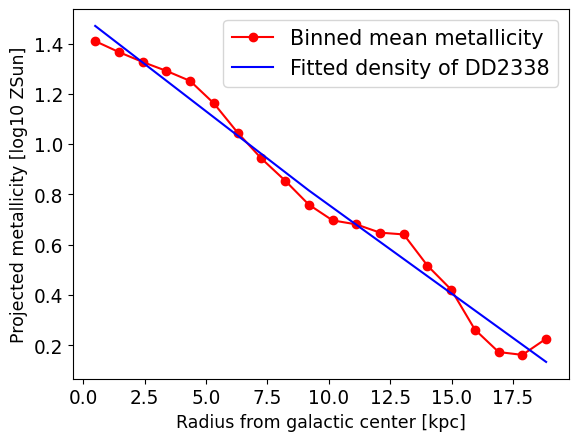

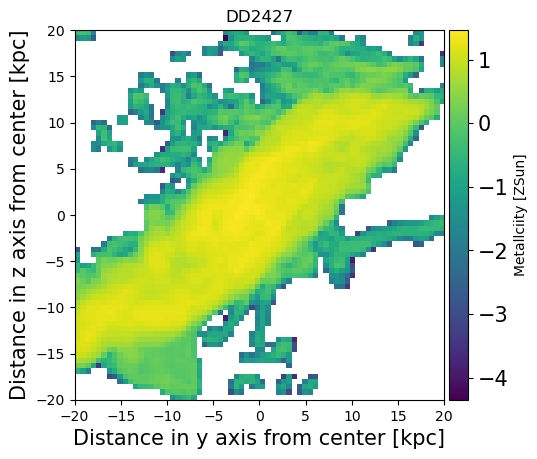

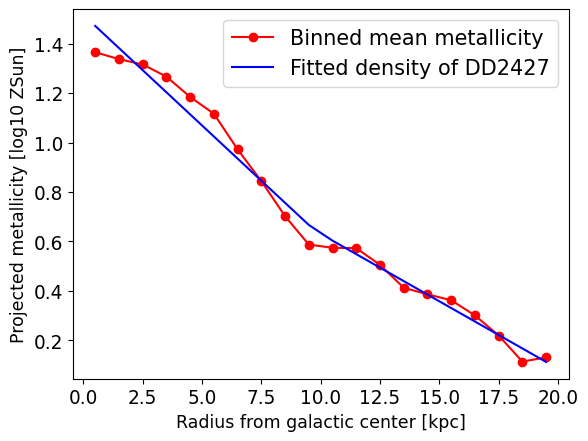

In [10]:
redshiftlist = [] #This part will be replaced with pandas later. 
cutofflist = [] #same 
timelist = [] #same 

for DD in sorted_dd_list:
    try:  
        snap = DD  # name of the snapshot output 
        snap_fullpath = simulation_dir + snap + '/' + snap # full path of where the snapshot output lives
        plotlabel_segment = 'Fitted density of' + " " + snap
        ds, refine_box = foggie_load(snap_fullpath, track_name, halo_c_v_name=track_dir + 'halo_c_v',
                                  disk_relative=False, do_filter_particles=False, masses_dir=track_dir)
        
        z = ds.get_parameter("CosmologyCurrentRedshift")
        current_time = ds.current_time.in_units('Gyr').value
        width = 40/(1+z) #[kpc]
        max_radius = width/2 #[kpc]
        binsize = 1/(z+1) #[kpc]
        
        rho_cut = get_density_cut(current_time)
        new_refine_box = refine_box.cut_region(['obj["gas", "density"] > %.1E' % rho_cut])
    
        frb = frb_projection(ds, field, axis, new_refine_box, width, resolution, weight_field = "mass")

        OD_Rad, OD_Qua = radius_func(np.array(frb["gas",field]), width, resolution)

        radiuslist, quantitylist =  binning_func(OD_Rad, OD_Qua, max_radius, min_radius, binsize)
        
        # Code below solves NaN error
        nanmask = [np.where(np.array(quantitylist)!=0)][0]
        new_quantity = np.array(quantitylist)[nanmask]
        new_radius = np.array(radiuslist)[nanmask]
        
        
        p , e = optimize.curve_fit(piecewise_linear, new_radius, np.log10(new_quantity), p0 = [5,21,-0.1,-0.075])
        #p : popt(optimization parameter) / e : pcov(covariance of popt)

        projection_plot = projection(frb, field, width, colorlabel, axis, snap, fontsize = 15)
        segment_plot = plotting(new_radius, np.log10(new_quantity), piecewise_linear(new_radius, *p),
                        'ro-','b-', plotlabel_linedot, plotlabel_segment)
 
        segment_plot.savefig(output_dir + snap + "_Density_Profile.jpg", bbox_inches = 'tight')
        projection_plot.savefig(output_dir + snap + "_Density_Projection_Plot.jpg")
    
        timepara = ds.current_time.in_units('Gyr').value + 0
        redshiftlist.append(z) #[z]
        cutofflist.append(p[0]) #[kpc]
        timelist.append(timepara) #[Gyr]
        
    except:
        print("Error with" +" "+ snap)
        pass     

In [11]:
#pandadata = {'Rdshift' : redshiftlist, 'Current time' : timelist, 'Cut-off radius' : cutofflist}
#Pd_dataframe = pd.DataFrame(data=d)
#Pd_dataframe4

In [12]:
cutofflist

[-312.8774506415258,
 309.1340917628378,
 0.40328831931763615,
 5.126424765582574,
 0.9620991521983517,
 2.500260185794901,
 5.140322232391854,
 -10.615084710966919,
 7.139130291960411,
 4.303261989082022,
 5.237853168623056,
 5.525560220953896,
 6.3321005723314725,
 78.34871626051688,
 6.565582418564697,
 5.759991936094718,
 5.666370297522297,
 5.446281371581051,
 7.084931467555971,
 4.679384978407135,
 8.542759216050111,
 7.481599915093157,
 6.660021370994752,
 10.815078107825862,
 12.511371189270076,
 14.763318652651018,
 17.149273383964232,
 8.674669180460167,
 9.181671464036615,
 9.764122339877211]

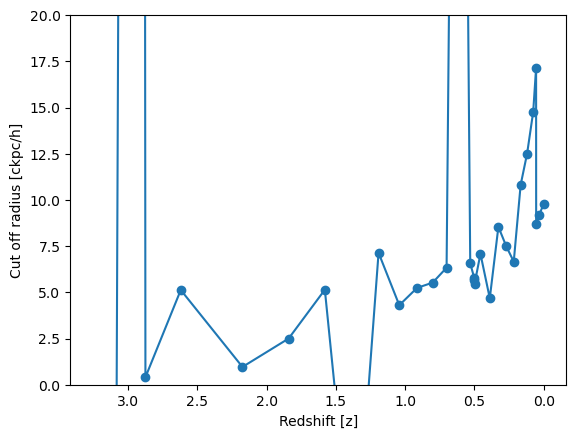

In [18]:
plt.plot(redshiftlist, cutofflist,'-o')
plt.ylabel("Cut off radius [ckpc/h]")
plt.ylim([0,20])
plt.xlabel("Redshift [z]")
plt.gca().invert_xaxis()

In [14]:
met_x_cutoff = cutofflist
#1st, density cut off too aggressive and 2nd, bounds for optimization. no negatifel. 

In [15]:
met_x_time = timelist

In [16]:
met_x_redshift = redshiftlist

In [19]:
np.save('met_x_cutoff', met_x_cutoff)
np.save('met_x_time', met_x_time)
np.save('met_x_redshift', met_x_redshift)